사용 장치: cuda:0
'ai_real_classifier.pth' 파일에서 성공적으로 모델을 불러왔습니다.


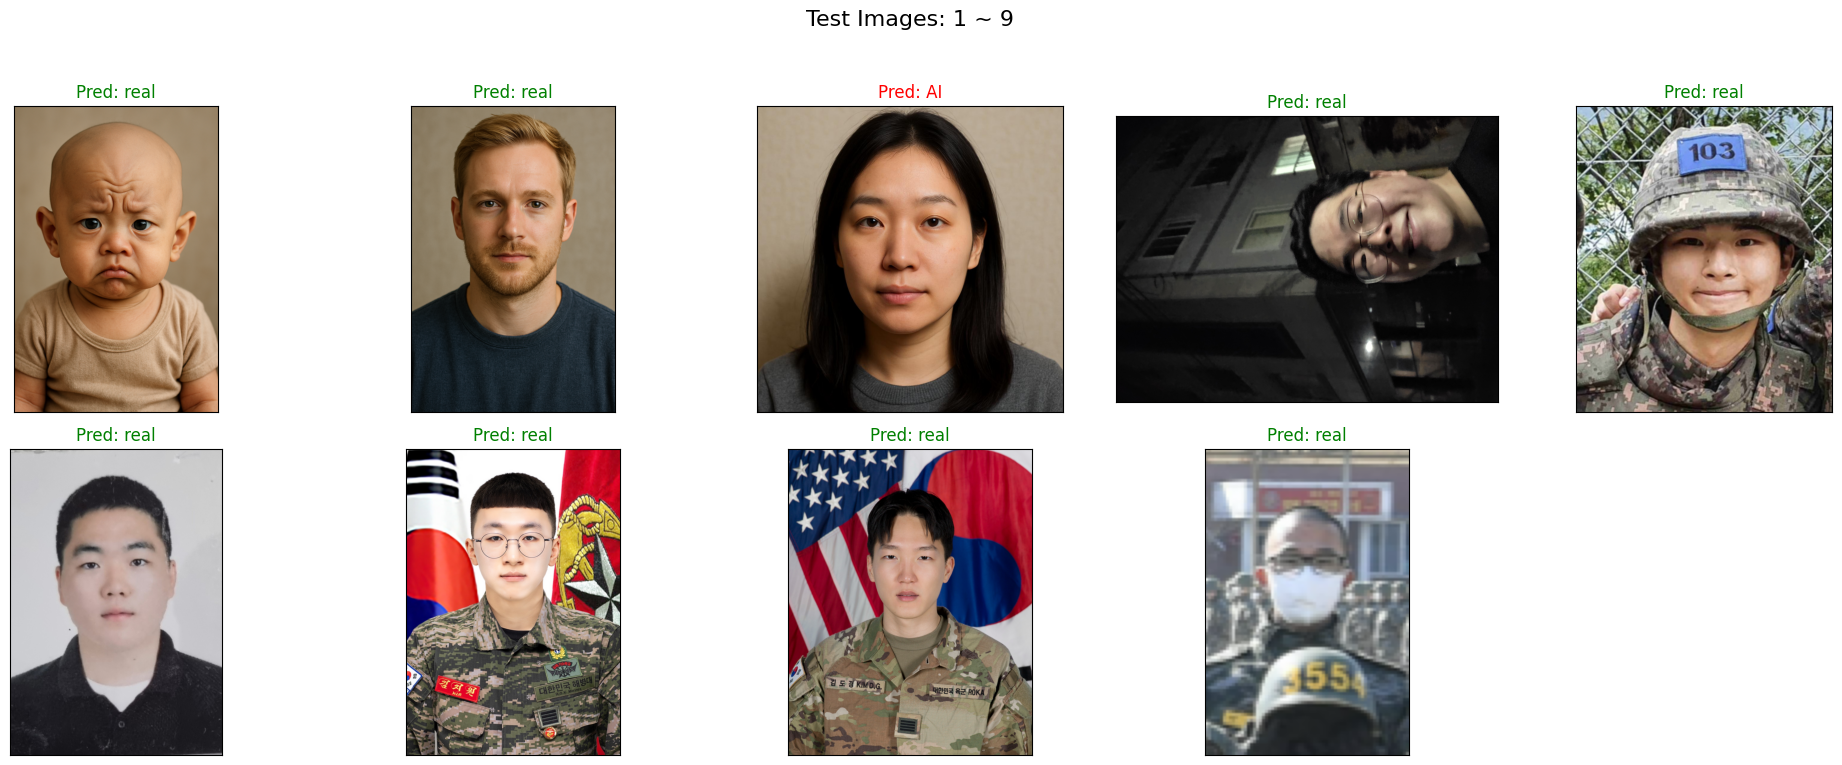

In [4]:
# 1. 라이브러리 및 기본 설정
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# GPU 또는 CPU 장치 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# 클래스 이름 (학습 때와 순서가 같아야 합니다: ['AI', 'real'])
class_names = ['AI', 'real']


# 2. 학습 때 사용한 모델 구조를 똑같이 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. 모델 객체 생성 및 .pth 파일 불러오기
model_to_load = SimpleCNN().to(device) # 모델 객체를 생성하고 device로 보냄
model_path = 'ai_real_classifier.pth'  # 저장된 pth 파일 경로

# .pth 파일에서 학습된 가중치(state_dict)를 불러와 모델에 적용
model_to_load.load_state_dict(torch.load(model_path, map_location=device))

# ★★★ 매우 중요: 모델을 추론(예측) 모드로 설정 ★★★
model_to_load.eval()

print(f"'{model_path}' 파일에서 성공적으로 모델을 불러왔습니다.")


# 4. 예측에 사용할 이미지 변환 정의
# (학습 시 'val'에 사용했던 변환과 동일해야 함)
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 5. 예측 수행 및 결과 시각화
# (이전 답변과 동일한 메모리 관리 코드)
def predict_image(image_path, model, transform):
    # model.eval()은 이미 밖에서 호출했으므로 여기서는 생략 가능
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return class_names[predicted.item()]

test_dir = './test/'
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
images_per_plot = 10

for i in range(0, len(test_image_paths), images_per_plot):
    batch_paths = test_image_paths[i:i + images_per_plot]
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle(f"Test Images: {i+1} ~ {i+len(batch_paths)}", fontsize=16)

    for j, img_path in enumerate(batch_paths):
        try:
            # 불러온 모델 'model_to_load'를 사용
            prediction = predict_image(img_path, model_to_load, predict_transform)
            img = Image.open(img_path)
            ax = fig.add_subplot(2, 5, j + 1, xticks=[], yticks=[])
            ax.imshow(img)
            ax.set_title(f"Pred: {prediction}", color=("green" if "real" in prediction else "red"))
        except Exception as e:
            print(f"오류 발생: {img_path}, 내용: {e}")
            ax = fig.add_subplot(2, 5, j + 1, xticks=[], yticks=[])
            ax.set_title("Error loading", color="blue")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()